In [1]:
import cv2     # for capturing videos
import math   # for mathematical operations
import matplotlib.pyplot as plt    # for plotting the images
%matplotlib inline
import pandas as pd
# from keras.preprocessing import image   # for preprocessing the images
import numpy as np    # for mathematical operations
# from keras.utils import np_utils
# from skimage.transform import resize   # for resizing images
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split
import random as rnd
from glob import glob
from tqdm import tqdm
import os

datadir = "/home/ephy/Projects/tda_convolve_video/data/original/KTH/"

from PIL import Image
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torchvision import transforms, datasets
device='cuda:0'

from scipy.integrate import quad
from scipy.integrate import dblquad
from scipy.integrate import tplquad
from scipy.ndimage import rotate as scipy_rotate
from scipy.ndimage import shift as scipy_shift
from joblib import Parallel, delayed

# Parse videos

In [2]:
classes = os.listdir(datadir)
classes = [c for c in classes if c!='scenes.txt']

In [3]:
f = open(datadir+'scenes.txt', "r")
scenes = []
for x in f:
    if '-' in x:
        parts = x.split('\t')
        name = parts[0].strip()+'_uncomp.avi'
        parts = parts[-1] 
        parts = parts.split(', ')
        starts = [part.split('-')[0] for part in parts]
        starts = np.array(starts, dtype=np.int)
        scenes.append((name,starts))

In [4]:
videos = []
y = []
for c in classes:
    d = os.listdir(datadir + c)
    for f in d:
        y.append(c)
        videos.append(f)
labels=np.array(y)

In [5]:
labels = np.repeat(labels, [len(scene[1]) for scene in scenes])
ds = [scene[0].split('_')[2] for scene in scenes for s in scene[1]]
len(ds)
persons = [scene[0].split('_')[0] for scene in scenes for s in scene[1]]
# nums = [str(i) for scene in scenes for i in range(len(scene[1]))]
stratLabels = [lab+d+person for (lab,d,person) in zip(labels,ds,persons)]

In [6]:
np.unique(stratLabels).shape

(120,)

In [7]:
#Factor of 2.77 shrink getws us very close to 100^2 pixels, same as experiments before, but with aspect preserved
# imageSize=np.array([np.round(160/1.3), np.round(120/1.3)],dtype=np.int)
imageSize=np.array([90,60])

In [8]:
videos = [(videos[i],y[i]) for i in range(len(y))]

In [9]:
# # storing the frames from training videos
# all_image = []
# for (video,clss) in tqdm(videos):
#     count = 0
#     cap = cv2.VideoCapture(datadir+clss+'/'+video)   # capturing the video from the given path
#     frameRate = 1 #frame sample rate
#     frames = []
#     startPoints = list(filter(lambda x: x[0]==video, scenes))
#     startPoints = startPoints[0][1]-1 # (Indexed from 1)
#     while(cap.isOpened()):
#         frameId = cap.get(1) #current frame number
#         ret, frame = cap.read()
#         if (ret != True):
#             break
#         if (frameId % math.floor(frameRate) == 0):
#             frames.append(frame)
#             count+=1
#     cap.release()
#     frames = np.stack(frames)
#     for start in startPoints:
#         clip = []
#         for f in range(start,start+23):
#             image = frames[f]
#             image = Image.fromarray(image , 'RGB')
#             image = image.crop((35,30,160-35,120-30)) #(left, top, right, bottom)
#             image = np.array(image)/255
#             image = np.dot(image[...,:3], [0.2989, 0.5870, 0.1140])
#             clip.append(image)
#         all_image.append(clip)
# all_image = np.stack(all_image)    

In [10]:
# # storing the frames from training videos
# all_image = []
# for (video,clss) in tqdm(videos):
#     count = 0
#     cap = cv2.VideoCapture(datadir+clss+'/'+video)   # capturing the video from the given path
#     frameRate = 1 #frame sample rate
#     frames = []
#     startPoints = list(filter(lambda x: x[0]==video, scenes))
#     startPoints = startPoints[0][1]-1 # (Indexed from 1)
#     while(cap.isOpened()):
#         frameId = cap.get(1) #current frame number
#         ret, frame = cap.read()
#         if (ret != True):
#             break
#         if (frameId % math.floor(frameRate) == 0):
#             frames.append(frame)
#             count+=1
#     cap.release()
#     frames = np.stack(frames)
#     for start in startPoints:
#         clip = []
#         for f in range(start,start+23):
#             image = frames[f]
#             image = Image.fromarray(image , 'RGB')
#             image = image.resize(imageSize)
#             image = np.array(image)/255
#             image = np.dot(image[...,:3], [0.2989, 0.5870, 0.1140])
#             clip.append(image)
#         all_image.append(clip)
# all_image = np.stack(all_image)    

In [11]:
# np.save('/home/ephy/Projects/tda_convolve_video/data/altered/KTH_FFR_23frames_focal.npy',all_image)
# all_image=np.load('/home/ephy/Projects/tda_convolve_video/data/altered/KTH_FFR_23frames_focal.npy', allow_pickle=True)

In [12]:
# np.save('/home/ephy/Projects/tda_convolve_video/data/altered/KTH_FFR_23frames.npy',all_image)
all_image=np.load('/home/ephy/Projects/tda_convolve_video/data/altered/KTH_FFR_23frames.npy', allow_pickle=True)

In [13]:
imageSize=(23,90,60)

In [14]:
filters77_r = np.load('/home/ephy/Projects/tda_convolve_video/src/python3/VideoFeatures_5x11x11_movAndRot120.npy', allow_pickle=True)
filters77 = np.load('/home/ephy/Projects/tda_convolve_video/src/python3/VideoFeatures_5x11x11_movAndRot120.npy', allow_pickle=True)
filters_2 = np.load('/home/ephy/Projects/tda_convolve_video/src/python3/VideoFeatures_394_movAndRot320.npy', allow_pickle=True)

In [15]:
def test(net, X, y, batchSize):
    confusionMatrix = np.zeros([101,101], dtype=np.int8)
    testingSeq = list(range(0,y.shape[0],batchSize))
    testingSeq.append(y.shape[0]+1)
    testingSeq = np.array(testingSeq)
    with torch.no_grad():
        for i in range(len(testingSeq)-1):
            data = X[testingSeq[i]:testingSeq[i+1]].view(-1,1,*imageSize).to(device)
            out = torch.argmax(net(data),axis=1).cpu()
            yt = torch.argmax(y[testingSeq[i]:testingSeq[i+1]],axis=1)
            for pred,label in zip(out,yt):
                confusionMatrix[label][pred] +=1
    del data
    del out
    del yt
    return confusionMatrix

In [16]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.convRescale = nn.Conv3d(1, 120, (5,11,11), bias=False,stride=(1,3,3))
        self.conv1 = nn.Conv3d(120, 120, (5,11,11), bias=False,stride=(1,2,2))
        self.conv2 = nn.Conv3d(120, 320, (3,9,4),bias=False)
        
        self.batchConv1 = nn.BatchNorm3d(120)
        self.batchConv2 = nn.BatchNorm3d(120)
        self.batchConv3 = nn.BatchNorm3d(320)
        
        self.drop1=nn.Dropout3d(.2)
        self.drop2=nn.Dropout3d(.2)
                
        x= torch.randn(1,1,*imageSize)
        self._to_linear = None
        self.convs(x)
        
        self.fc1 = nn.Linear(self._to_linear, 6)
        self.batch1 = nn.BatchNorm1d(6)
        
    def convs(self, x):
        x = F.leaky_relu(self.convRescale(x))
#         x = self.batchConv1(x)
        x = F.leaky_relu(self.conv1(x))
#         x = self.batchConv2(x)
#         x = self.drop1(x)
        x = F.leaky_relu(self.conv2(x))
#         x = self.batchConv3(x)
#         x = self.drop2(x)
#         print(x.shape)
        
        if self._to_linear is None:
            self._to_linear = x[0].shape[0]*x[0].shape[1]*x[0].shape[2]*x[0].shape[3]
#             print(self._to_linear)
            
        return x
    
    def forward(self, x):
        x = self.convs(x)
        x = x.view(-1, self._to_linear)
        x = self.fc1(x)
        x = self.batch1(x)
        return F.softmax(x, dim=1)

In [17]:
net = Net().to(device)
torch.cuda.memory_allocated()*1e-9

0.052834304000000006

In [18]:
labels = np.array(pd.get_dummies(labels))

In [33]:
EPOCHS = 500
# Batch size of 26+1, because normalization requires same batch size and 4472%26=0 (very close to even split) (same logic for training)
testingBatchSize=100
trainingBatchSize=100
results = [[],[],[]]
lossrec = [[],[],[]]

for foldIndex in range(1):

    net = Net().to(device)
    optimizer = optim.AdamW(net.parameters(), lr=9e-3)

    # Set filters in 2 layers
    with torch.no_grad():
        for i,weights in enumerate(filters77_r):
            net.convRescale.weight[i] = torch.nn.Parameter(torch.tensor(weights)).to(device)
        for i,weights in enumerate(filters77_r):
            net.conv1.weight[:,i,...] = torch.nn.Parameter(torch.tensor(filters77)).to(device)
        for i,weights in enumerate(filters77):
            net.conv2.weight[:,i,...] = torch.nn.Parameter(torch.tensor(filters_2)).to(device)
        net.convRescale.requires_grad=False
        net.conv1.requires_grad=False
        net.conv2.requires_grad=False

    print('Network Reset.')  

    X_train, X_test, y_train, y_test = train_test_split(all_image, labels,
                                                        shuffle=True, random_state=foldIndex,
                                                        test_size=0.1, stratify = stratLabels)

    y_test = torch.tensor(y_test,dtype=torch.float32)
    X_train = torch.tensor(X_train,dtype=torch.float32)
    X_test =  torch.tensor(X_test,dtype=torch.float32)
    y_train = torch.tensor(y_train,dtype=torch.float32)

    trainingSeq = list(range(0,y_train.shape[0],trainingBatchSize))
    trainingSeq.append(y_train.shape[0]+1)
    trainingSeq = np.array(trainingSeq)

    for epoch in range(EPOCHS):
        for i in range(len(trainingSeq)-1):
            X=X_train[trainingSeq[i]:trainingSeq[i+1]].view(-1,1,*imageSize)
            X=X.to(device)
            y=y_train[trainingSeq[i]:trainingSeq[i+1]]
            y=y.to(device)
            net.zero_grad()
            output = net(X)
            loss = nn.CrossEntropyLoss()(output, torch.argmax(y, axis=1))
            lossrec[foldIndex].append(float(loss.tolist()))
            loss.backward()
            optimizer.step()
            del loss
            del output
            del X
            del y
            
        print('Fold: ', foldIndex, 'Epoch: ',epoch)
        results[foldIndex].append(test(net, X_test, y_test, testingBatchSize))
        cm = results[foldIndex][len(results[foldIndex])-1]
        print('Accuracy: ' , np.sum(np.diag(cm))/np.sum(cm))

# np.save('/home/ephy/Projects/tda_convolve_video/data/altered/KTH_net8_k1layer_30_res.npy', results)
# np.save('/home/ephy/Projects/tda_convolve_video/data/altered/KTH_net8_k1layer_30_loss.npy', lossrec)

Network Reset.


/home/ephy/anaconda3/envs/opencvenv/lib/python3.7/site-packages/ipykernel_launcher.py:35: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/ephy/anaconda3/envs/opencvenv/lib/python3.7/site-packages/ipykernel_launcher.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Fold:  0 Epoch:  0
Accuracy:  0.3458333333333333
Fold:  0 Epoch:  1
Accuracy:  0.4125
Fold:  0 Epoch:  2
Accuracy:  0.5708333333333333
Fold:  0 Epoch:  3
Accuracy:  0.6541666666666667
Fold:  0 Epoch:  4
Accuracy:  0.7083333333333334
Fold:  0 Epoch:  5
Accuracy:  0.7458333333333333
Fold:  0 Epoch:  6
Accuracy:  0.7833333333333333
Fold:  0 Epoch:  7
Accuracy:  0.8125
Fold:  0 Epoch:  8
Accuracy:  0.8125
Fold:  0 Epoch:  9
Accuracy:  0.8208333333333333
Fold:  0 Epoch:  10
Accuracy:  0.8125
Fold:  0 Epoch:  11
Accuracy:  0.7833333333333333
Fold:  0 Epoch:  12
Accuracy:  0.825
Fold:  0 Epoch:  13
Accuracy:  0.8208333333333333
Fold:  0 Epoch:  14
Accuracy:  0.8458333333333333
Fold:  0 Epoch:  15
Accuracy:  0.8375
Fold:  0 Epoch:  16
Accuracy:  0.8208333333333333
Fold:  0 Epoch:  17
Accuracy:  0.8166666666666667
Fold:  0 Epoch:  18
Accuracy:  0.8125
Fold:  0 Epoch:  19
Accuracy:  0.825
Fold:  0 Epoch:  20
Accuracy:  0.8375
Fold:  0 Epoch:  21
Accuracy:  0.8333333333333334
Fold:  0 Epoch:  22


KeyboardInterrupt: 

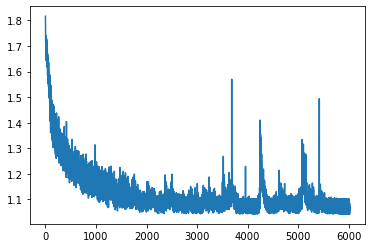

In [31]:
plt.plot(lossrec[0])

0.12916666666666665


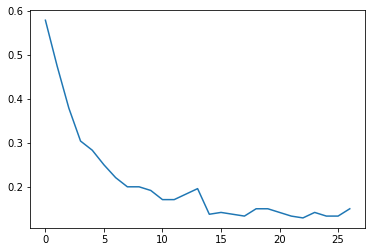

In [23]:
gresults = [1 - np.sum(np.diag(cm))/np.sum(cm) for cm in results[0]]
print(min(gresults))
plt.plot(gresults)

In [ ]:
# Need uneven kernels to go full klein

In [ ]:
# Got 93.3% accuracy
# class lstm_Net(nn.Module):
#     def __init__(self):
#         super().__init__()
        
#         self.convRescale = nn.Conv3d(1, 180, (5,7,7), bias=False)
#         self.conv1 = nn.Conv3d(180, 100, (1,8,5))
#         self.conv2 = nn.Conv3d(100, 100, (1,8,5))
        
#         self.batchConv1 = nn.BatchNorm3d(180)
#         self.batchConv2 = nn.BatchNorm3d(100)
#         self.batchConv3 = nn.BatchNorm3d(100)
        
#         self.drop1=nn.Dropout3d(.2)
                
#         x= torch.randn(1,1,*imageSize)
#         self._to_linear = None
#         self.convs(x)
        
# #         self.fc1 = nn.Linear(self._to_linear, 200)
#         self.batch1 = nn.BatchNorm1d(200)        
#         self.lstm = nn.LSTM(self._to_linear,200)
#         self.fc2 = nn.Linear(200, 6)

        
#     def convs(self, x):
#         x = F.relu(F.max_pool3d(self.convRescale(x),(1,3,3)))
#         x = self.batchConv1(x)
# #         x = self.drop1(x)
#         x = F.relu(F.max_pool3d(self.conv1(x),(1,2,2)))
#         x = self.batchConv2(x)
#         x = F.relu(F.max_pool3d(self.conv2(x),(1,2,2)))
#         x = self.batchConv3(x)
#         print(x.shape)
        
#         if self._to_linear is None:
#             self._to_linear = x[0].shape[0]*x[0].shape[1]*x[0].shape[2]*x[0].shape[3]
            
#         return x
    
#     def forward(self, x):
#         hidden = [torch.randn(1, x.shape[0], self._to_linear).to(device),torch.randn(1, x.shape[0], 200).to(device)]
#         out = torch.zeros(12,x.shape[0],200).to(device)
#         for i in range(x.shape[1]):
#             xi = x[:,i,...].view(x.shape[0],1,*imageSize)
#             xi = self.convs(xi)
#             print(xi.shape)
#             xi = xi.view(-1, self._to_linear)
#             out[i,...] = xi
#         del xi
#         del x
#         out, hidden = self.lstm(out,hidden)
#         x = F.relu(out[-1])
#         x = self.batch1(x)
#         x = self.fc2(x)
#         return F.softmax(x, dim=1)

In [ ]:
# filters77 = np.load('/home/ephy/Projects/tda_convolve_video/src/python3/VideoFeatures_555_movAndRot80.npy', allow_pickle=True)
class lstm_Net(nn.Module):    
    def __init__(self):        
        super().__init__()
        
        self.lstmOutSize = 50
        
        self.convRescale = nn.Conv3d(1, 20, (5,5,5), bias=False)
        self.conv1 = nn.Conv3d(20, 40, (1,5,5))
        self.conv2 = nn.Conv3d(40, 320, (1,8,5))
        
        self.batchConv1 = nn.BatchNorm3d(20)
        self.batchConv2 = nn.BatchNorm3d(40)
        self.batchConv3 = nn.BatchNorm3d(320)
        
#         self.drop1=nn.Dropout3d(.5)
                
        x= torch.randn(1,1,*imageSize)
        self._to_linear = None
        self.convs(x)
        
        #         self.fc1 = nn.Linear(self._to_linear, 200)
        self.batch1 = nn.BatchNorm1d(self.lstmOutSize)     
        self.batch2 = nn.BatchNorm1d(6)
        self.lstm = nn.LSTM(self._to_linear,self.lstmOutSize)
        self.fc2 = nn.Linear(self.lstmOutSize, 6)
        
    def convs(self, x):
        x = F.relu(F.max_pool3d(self.convRescale(x),(1,3,3)))
        x = self.batchConv1(x)
#         x = self.drop1(x)
        x = F.relu(F.max_pool3d(self.conv1(x),(1,2,2)))
        x = self.batchConv2(x)
        x = F.relu(F.max_pool3d(self.conv2(x),(1,2,2)))
        x = self.batchConv3(x)
        
        if self._to_linear is None:
            self._to_linear = x.shape[1]*x.shape[3]*x.shape[4]
            
        return x
    
    
    def forward(self, x):
        x = self.convs(x)
        batchSize = x.shape[0]
        x = torch.transpose(x,0,2)
        x = torch.transpose(x,1,2)
        x = x.reshape(x.shape[0],x.shape[1],np.prod(x.shape[2:]))
        hidden = [torch.randn(1, batchSize, self.lstmOutSize).to(device),torch.randn(1, batchSize, self.lstmOutSize).to(device)]
        x, hidden = self.lstm(x,hidden)
        x = F.relu(x[-1])
        x = self.batch1(x)
        x = self.fc2(x)
        x = self.batch2(x)
        return F.softmax(x, dim=1)

In [ ]:
net = lstm_Net().to(device)
torch.cuda.memory_allocated()*1e-9

In [ ]:
EPOCHS = 500
# Batch size of 26+1, because normalization requires same batch size and 4472%26=0 (very close to even split) (same logic for training)
testingBatchSize=100
trainingBatchSize=100
results = [[],[],[]]
lossrec = [[],[],[]]
lr=2e-3

for foldIndex in range(1):

    net = lstm_Net().to(device)
    optimizer = optim.Adam(net.parameters(), lr=lr)

    # Set filters in 2 layers
    with torch.no_grad():
        for i,weights in enumerate(filters77):
            net.convRescale.weight[i] = torch.nn.Parameter(torch.tensor(weights)).to(device)
        net.convRescale.requires_grad=False

    print('Network Reset.')  

    X_train, X_test, y_train, y_test = train_test_split(all_image, labels,
                                                        shuffle=True, random_state=foldIndex,
                                                        test_size=0.1, stratify = stratLabels)

    y_train = torch.tensor(y_train,dtype=torch.float32)
    y_test = torch.tensor(y_test,dtype=torch.float32)
    X_train = torch.tensor(X_train,dtype=torch.float32)
    X_test =  torch.tensor(X_test,dtype=torch.float32)
    y_train = torch.tensor(y_train,dtype=torch.float32)
    y_test = torch.tensor(y_test,dtype=torch.float32)

    trainingSeq = list(range(0,y_train.shape[0],trainingBatchSize))
    trainingSeq.append(y_train.shape[0]+1)
    trainingSeq = np.array(trainingSeq)

    for epoch in range(EPOCHS):
#         if epoch!=0 and epoch%15==0:
#             lr = lr*1e-10
#             for param_group in optimizer.param_groups:
#                 param_group['lr'] = lr
        for i in range(len(trainingSeq)-1):
            X=X_train[trainingSeq[i]:trainingSeq[i+1]].view(-1,1,*imageSize)
            X=X.to(device)
            y=y_train[trainingSeq[i]:trainingSeq[i+1]]
            y=y.to(device)
            net.zero_grad()
            output = net(X)
            loss = nn.CrossEntropyLoss()(output, torch.argmax(y, axis=1))
            lossrec[foldIndex].append(float(loss.tolist()))
            loss.backward()
            optimizer.step()
            del loss
            del output
            del X
            del y
            
        print('Fold: ', foldIndex, 'Epoch: ',epoch)
        results[foldIndex].append(test(net, X_test, y_test, testingBatchSize))
        cm = results[foldIndex][len(results[foldIndex])-1]
        print('Accuracy: ' , np.sum(np.diag(cm))/np.sum(cm))

# np.save('/home/ephy/Projects/tda_convolve_video/data/altered/KTH_net8_k1layer_30_res.npy', results)
# np.save('/home/ephy/Projects/tda_convolve_video/data/altered/KTH_net8_k1layer_30_loss.npy', lossrec)

In [ ]:
gresults = [np.sum(np.diag(cm))/np.sum(cm) for cm in results[0]]
max(gresults)

In [ ]:
plt.plot(lossrec[0])

In [ ]:
plt.plot(gresults)

In [ ]:
a = np.array([[[1,2,3],[3,4,3]],[[9,9,9],[9,9,9]]]*5)
print(a)
# print(a.shape)
a = a.reshape(a.shape[1],a.shape[0]*a.shape[2])
# print(a.shape)
print(a)